In [1]:
import sys
##!!! 这里把路径换成自己工作目录
sys.path.append("/home/ai/project/mas-gan")
from model.maslayer import Generator
import matplotlib.pyplot as plt
import configparser
import torch
import random

## 设置随机种子
manualSeed = 0
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  0


In [2]:
## 超参数
class Args:
    batch_size = 100
    epochs = 500
    input_shape = (10, 1)
    output_shape = (10, 1)
    lr = 0.001
    mu1 = 100.0
    mu2 = 0.01
    nu1 = 0.1
    nu2 = 0.1
    num_samples = [7, 5, 3]
    param_b = 1.0
    param_c = 1.0
    param_d = 0.5
    param_init = True
    param_b_init = 0.6
    param_c_init = 0.6
    param_d_init = 0.1
    rho = 0.15
    sigma_i = 0
    sigma_p = 1
    project = "MAS"
    name = "test"
    logs_dir = "logs"
    device = 'cpu'

args=Args()

In [3]:
## 根据args获取数据
from model.dataset import get_dataset

in_price, in_price_star, in_sigma, out_price = get_dataset(args)
print(in_price.shape) # 输入price
print(in_price_star.shape) # 输入price_star
print(in_sigma.shape) # 输入sigma
print(out_price.shape) # 输出价格

torch.Size([4000, 10, 1])
torch.Size([4000, 10, 1])
torch.Size([4000, 10, 1])
torch.Size([4000, 10, 1])


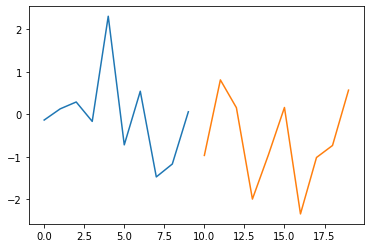

In [4]:
## 输入，输出曲线
plt.plot([_ for _ in range(10)], in_price[0, :, 0])
plt.plot([_ for _ in range(10, 20)], out_price[0, :, 0])

torch.Size([4000, 340])


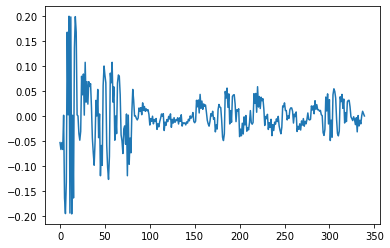

In [5]:
from model.massignature import MASignature
model = MASignature(args)
sig_in_p = model.signature(in_price) ## 对输入价格进行路径签名
# sig_in_p = signature(in_price) ## 对输入价格进行路径签名

print(sig_in_p.shape)
plt.plot(sig_in_p[0])

torch.Size([4000, 340])


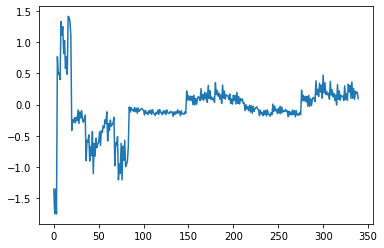

In [6]:
target_sig = model.get_lr_sigs_pred(in_price, out_price) ## b=1, c=1, d=0.5 时目标signature
print(target_sig.shape)
plt.plot(target_sig[0])

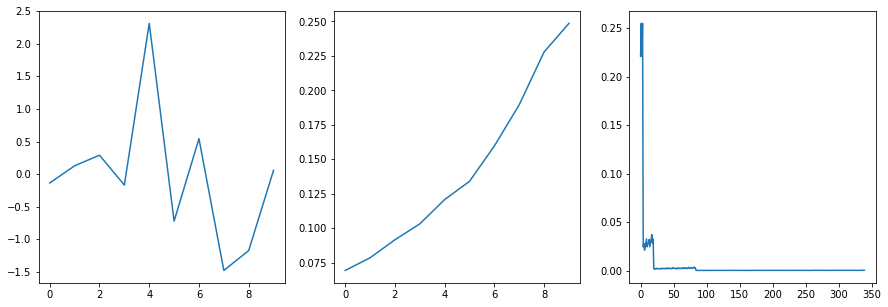

[*] b=0.6, c=0.6, d=0.1
L1 diff: 7026.96
L2 diff: 1919290.2


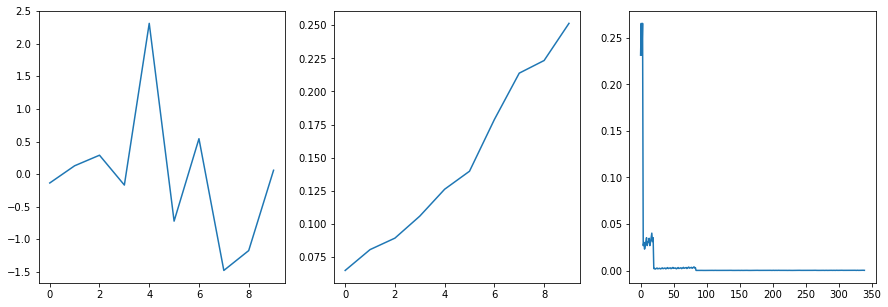

[*] b=0.9, c=0.9, d=0.4
L1 diff: 8667.729
L2 diff: 3740028.0


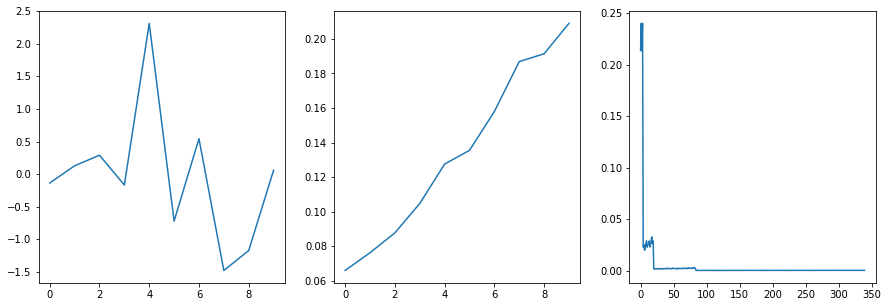

[*] b=1.0, c=1.0, d=0.5
L1 diff: 10062.938
L2 diff: 7128730.5


In [11]:
import numpy as np
def diffScore(model: MASignature, in_price: torch.Tensor, in_price_star: torch.Tensor, \
        in_sigma: torch.Tensor, target_sig: torch.Tensor, b: float, c: float, d: float):
    """计算在给定的b，c，d参数下模型的输出与b=1，c=1, d=0.5下的结果的差距

    Args:
        model (MASignature): 模型
        in_price (torch.Tensor): 输入price
        in_price_star (torch.Tensor): 输入price-star
        target_sig (torch.Tensor): 在b=1，c=1, d=0.5时目标signature结果
        b (float): 目前的b
        c (float): 目前的c
        d (float): 目前的d
    """
    for name, param in model.generator.named_parameters():
        if name == "mas_cell.noise_traders.param_b":
            torch.nn.init.constant_(param, b)
        if name == "mas_cell.noise_traders.param_c":
            torch.nn.init.constant_(param, c)
        if name == "mas_cell.technical_traders.param_d":
            torch.nn.init.constant_(param, d)
    model.generator.eval()
    plt.figure(figsize=(15, 5))
    gen_price, _, _ = model.generator(in_price, in_price_star, in_sigma)
    plt.subplot(1, 3, 1)
    plt.plot(in_price[0])
    plt.subplot(1, 3, 2)
    plt.plot(gen_price.detach().numpy()[0])
    gen_price_sig = model.signature(gen_price)
    gen_price_sig = gen_price_sig.detach().numpy()
    target_sig = target_sig.detach().numpy()
    plt.subplot(1, 3, 3)
    plt.plot(gen_price_sig[0])
    plt.show()
    print(f"[*] b={b}, c={c}, d={d}")
    print("L1 diff:", np.mean(np.sum((gen_price_sig - target_sig), axis=1), axis=0))
    print("L2 diff:", np.mean(np.sum((gen_price_sig - target_sig) ** 2, axis=1), axis=0))

## 计算b=0.6, c=0.6, d=0.1时模型的输出结果与b=1，c=1, d=0.5的差距
diffScore(model, in_price, in_price_star, in_sigma, target_sig, b=0.6, c=0.6, d=0.1)
## 计算b=0.9, c=0.9, d=0.4时模型的输出结果与b=1，c=1, d=0.5的差距
diffScore(model, in_price, in_price_star, in_sigma, target_sig, b=0.9, c=0.9, d=0.4)
## 计算b=1.0, c=1.0, d=0.5时模型的输出结果与b=1，c=1, d=0.5的差距
diffScore(model, in_price, in_price_star, in_sigma, target_sig, b=1.0, c=1.0, d=0.5)

## 目标
- 通过改进MASignature.signature，使数据信息分布在整个曲线上
  - 参考：[Deep Signature Transforms](https://papers.nips.cc/paper/2019/file/d2cdf047a6674cef251d56544a3cf029-Paper.pdf) Fig5
- 通过设置不同的超参数使得Signature可以衡量待拟合参数的差异程度
  - 通过改进评价方式（目前是L1，L2），使得signature可以衡量参数的优劣
  - 通过改进signature的数据预处理方法，signature的超参数或者其他的路径签名方法使得可以衡量不同超参数的优劣